In [1]:
import numpy as np
import h5py
import cv2 
import os, sys
import matplotlib.pyplot as plt
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from copy import deepcopy as dcpy
import matplotlib.patches as patches

In [2]:
r_data = np.load("../result_data/221005_testdata_FBI_Net_Grayscale_Samsung_SET1_MSE_Affine_layers_x17_filters_x64.npy",mmap_mode='r')
print(r_data.shape)
img = r_data[0]
img_uint8 = (r_data[0]*255).astype('uint8')


(1500, 256, 256)


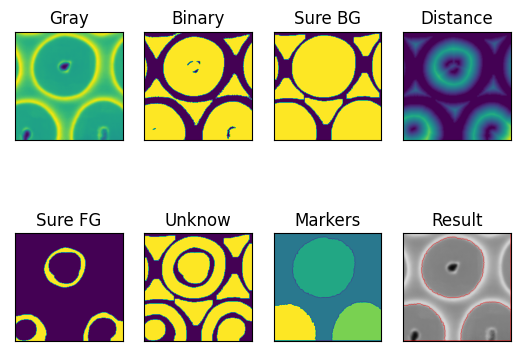

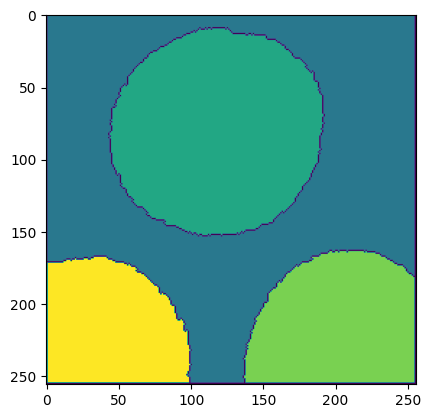

In [3]:
# https://opencv-python.readthedocs.io/en/latest/doc/27.imageWaterShed/imageWaterShed.html
import cv2
import numpy as np
from matplotlib import pyplot as plt


# img = cv2.imread('images/watershed.jpg')

gray = img_uint8
b = np.zeros((256,256,3)).astype('uint8')
b[:,:,0] = img_uint8
b[:,:,1] = img_uint8
b[:,:,2] = img_uint8

# binaray image로 변환
#gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

#Morphology의 opening, closing을 통해서 노이즈나 Hole제거
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=2)

# dilate를 통해서 확실한 Backgroud
sure_bg = cv2.dilate(opening,kernel,iterations=3)

#distance transform을 적용하면 중심으로 부터 Skeleton Image를 얻을 수 있음.
# 즉, 중심으로 부터 점점 옅어져 가는 영상.
# 그 결과에 thresh를 이용하여 확실한 FG를 파악
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)

# Background에서 Foregrand를 제외한 영역을 Unknown영역으로 파악
unknown = cv2.subtract(sure_bg, sure_fg)

# FG에 Labelling작업
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# watershed를 적용하고 경계 영역에 색지정
markers = cv2.watershed(b,markers)
b[markers == -1] = [255,0,0]


images = [gray,thresh,sure_bg,  dist_transform, sure_fg, unknown, markers, b]
titles = ['Gray','Binary','Sure BG','Distance','Sure FG','Unknow','Markers','Result']

for i in range(len(images)):
    plt.subplot(2,4,i+1),plt.imshow(images[i]),plt.title(titles[i]),plt.xticks([]),plt.yticks([])

plt.show()
plt.imshow(markers)

In [4]:
np.unique(markers)

array([-1,  1,  2,  3,  4], dtype=int32)

## Manipulated version

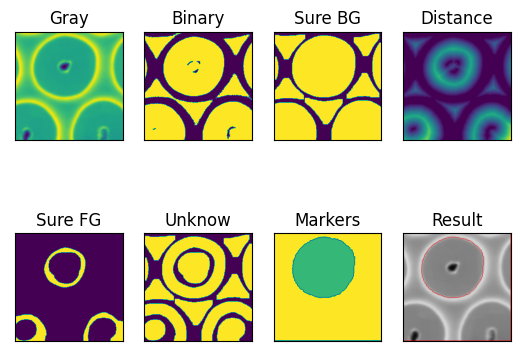

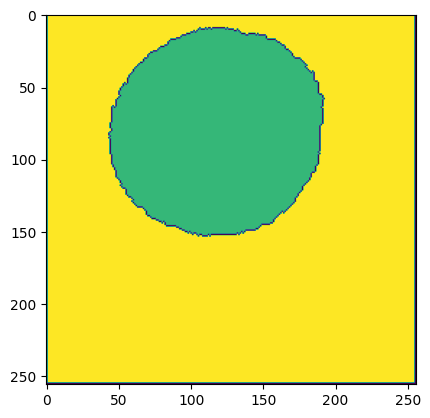

In [5]:
# https://opencv-python.readthedocs.io/en/latest/doc/27.imageWaterShed/imageWaterShed.html
import cv2
import numpy as np
from matplotlib import pyplot as plt


# img = cv2.imread('images/watershed.jpg')

gray = img_uint8
b = np.zeros((256,256,3)).astype('uint8')
b[:,:,0] = img_uint8
b[:,:,1] = img_uint8
b[:,:,2] = img_uint8

# binaray image로 변환
#gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# print(ret)
# plt.imshow(thresh)

#Morphology의 opening, closing을 통해서 노이즈나 Hole제거
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=2)

# dilate를 통해서 확실한 Backgroud
sure_bg = cv2.dilate(opening,kernel,iterations=3)

#distance transform을 적용하면 중심으로 부터 Skeleton Image를 얻을 수 있음.
# 즉, 중심으로 부터 점점 옅어져 가는 영상.
# 그 결과에 thresh를 이용하여 확실한 FG를 파악
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)

# Background에서 Foregrand를 제외한 영역을 Unknown영역으로 파악
unknown = cv2.subtract(sure_bg, sure_fg)

# FG에 Labelling작업
ret, markers = cv2.connectedComponents(sure_fg)
plt.imshow(markers)
# print(markers)
#target = 3
markers[markers==3] = 0 # to pick one circle
markers[unknown == 255] = 0
# print(markers)

# watershed를 적용하고 경계 영역에 색지정
markers = cv2.watershed(b,markers)
b[markers == -1] = [255,0,0]


images = [gray,thresh,sure_bg,  dist_transform, sure_fg, unknown, markers, b]
titles = ['Gray','Binary','Sure BG','Distance','Sure FG','Unknow','Markers','Result']

for i in range(len(images)):
    plt.subplot(2,4,i+1),plt.imshow(images[i]),plt.title(titles[i]),plt.xticks([]),plt.yticks([])

plt.show()
plt.imshow(markers)

[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0] [0 1]
117 80


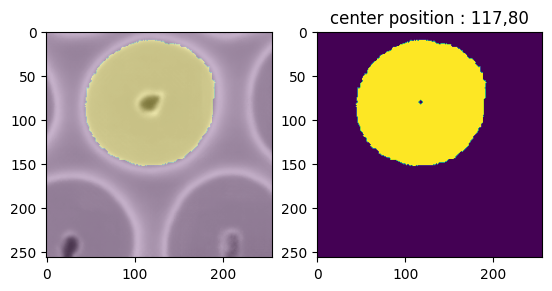

In [6]:
markers[markers != 1] = 0
print(markers[100][180:200], np.unique(markers))
markers = markers.astype('uint8')

plt.subplot(1,2,1)
plt.imshow(markers,alpha=0.6)
plt.imshow(img_uint8,cmap='gray',alpha=0.5)

# get central moments
M = cv2.moments(markers)

cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
print(cX, cY)
t = cv2.circle(dcpy(markers), (cX, cY), 2, (0, 0, 0), -1)
plt.subplot(1,2,2)
plt.title(f'center position : {cX},{cY}')
plt.imshow(t,alpha=1)

In [7]:
np.count_nonzero(markers[cX]),markers[cX]

(126,
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8))

In [8]:
i = 0
j = 0
find_right = False
find_left = False
print(cX,cY,markers[cX][cY])
while not find_right or not find_left:
    if find_right is False:
        i+=1
        if markers[cX][cY+i] == 0 :
            print("right : ",i)
            find_right = True
    if find_left is False:
        j-=1
        if markers[cX][cY+j] == 0 or cX-j <0 :
            print("left : ",j)    
            find_left = True
print(i-j-1)

117 80 1
left :  -28
right :  99
126


center : 117,80
angle :  30
x length, y length : 124 71
2*radius :  142.88806808127822


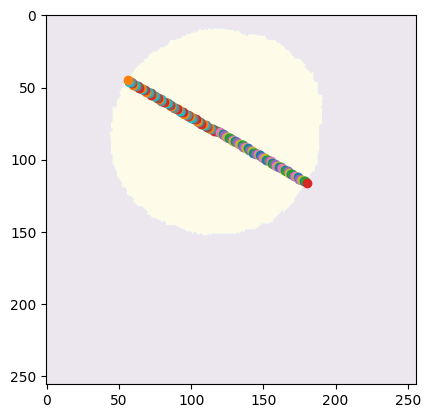

In [17]:
i = 0
j = 0
find_right = False
find_left = False
angle=30
print(f"center : {cX},{cY}")
print(f"angle : ",angle)
debug = True
while not find_right or not find_left:
    if find_right is False:
        i+= 1
        x1 = int(np.cos(np.pi / 180 * angle)*i)
        y1 = int(np.sin(np.pi / 180 * angle)*i)
        if debug is True:
            plt.scatter(cX+x1,cY+y1)
        if markers[cY+y1][cX+x1] == 0 :
            #print("right : ",y1)
            find_right = True
    if find_left is False:
        j-=1
        x2 = int(np.cos(np.pi / 180 * angle)*j)
        y2 = int(np.sin(np.pi / 180 * angle)*j)
        if debug is True:
            plt.scatter(cX+x2,cY+y2)
        if markers[cY+y2][cX+x2] == 0  :
            #print(markers[cX+x2][cY+y2],"left : ",y2)    
            find_left = True
#print(i-j-1)
# print(x1-x2,y1-y2)
x = x1-x2
y = y1-y2
print("x length, y length :",x,y)
print("2*radius : ",np.sqrt((x)**2 +(y)**2))
if debug is True:
    plt.imshow(t,alpha=0.1)

In [10]:
def get_minmax_CD(markers, cX, cY,debug=False):
    """
        markers : imgae where segmentation is done
        cX : center X (horizontal)
        cY : center Y (vertical)
    """
    minCD = 10000
    maxCD = -1
    for angle in range(0,180+1):
        i = 0
        j = 0
        find_right = False
        find_left = False
        if debug is True:
            print("center :",cX,cY)
            print(f"angle : ",angle)

        while not find_right or not find_left:
            if find_right is False:
                i+= 1
                x1 = int(np.cos(np.pi / 180 * angle)*i)
                y1 = int(np.sin(np.pi / 180 * angle)*i)
                if debug is True:
                    plt.scatter(cX+x1,cY+y1)
                if markers[cY+y1][cX+x1] == 0 :
                    #print("right : ",y1)
                    find_right = True
            if find_left is False:
                j-=1
                x2 = int(np.cos(np.pi / 180 * angle)*j)
                y2 = int(np.sin(np.pi / 180 * angle)*j)
                if debug is True:
                    plt.scatter(cX+x2,cY+y2)
                if markers[cY+y2][cX+x2] == 0  :
                    #print(markers[cX+x2][cY+y2],"left : ",y2)    
                    find_left = True
        #print(i-j-1)
        # print(x1-x2-1,y1-y2-1)
        x = x1-x2
        y = y1-y2
        diameter = np.sqrt((x)**2 +(y)**2)
        if debug is True:
            print("x length, y length :",x,y)
            print("2*radius(diameter) : ",diameter)
        if diameter == 0:
            print(angle)
            s
        if minCD > diameter:
            minCD = diameter
        if maxCD < diameter:
            maxCD = diameter
        if debug is True:
            plt.imshow(t,alpha=0.1)
            return
    return minCD,maxCD
get_minmax_CD(markers,cX,cY)

(141.65097952361643, 154.35349040433132)

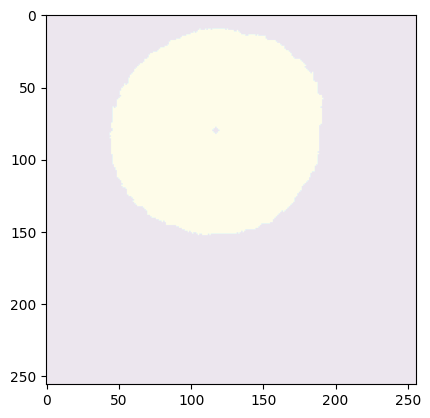

In [11]:
fig,ax = plt.subplots()

plt.imshow(t,alpha=0.1)
plt.show()

In [12]:
image_height = t.shape[0]
image_width = t.shape[1]
angle = 30
infinity = 10000
x_center = cX
y_center = cY
y_rotated = y_center + int(np.sin(np.pi / 180 * angle)*infinity)
x_rotated = x_center + int(np.cos(np.pi / 180 * angle)*infinity)
ret, inner_point, clipped_point = cv2.clipLine((0, 0, image_width-1, image_height-1), (x_center, y_center), (x_rotated, y_rotated))
t1 = cv2.line(dcpy(t), (x_center, y_center), clipped_point, (255, 0, 0))
"""
ax.add_patch(
     patches.Polygon(
        ((cX, cY), (cY+y1,cX+x1 ), (cY+y2,cX+x2)),
        closed=True,
        edgecolor = 'deeppink',
        facecolor = 'lightgray'
     ))
"""

"\nax.add_patch(\n     patches.Polygon(\n        ((cX, cY), (cY+y1,cX+x1 ), (cY+y2,cX+x2)),\n        closed=True,\n        edgecolor = 'deeppink',\n        facecolor = 'lightgray'\n     ))\n"

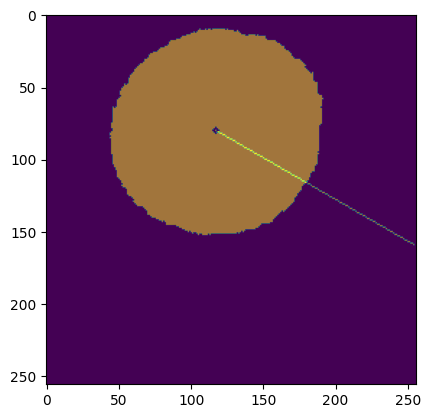

In [13]:
plt.imshow(t)
plt.imshow(t1,alpha=0.5)

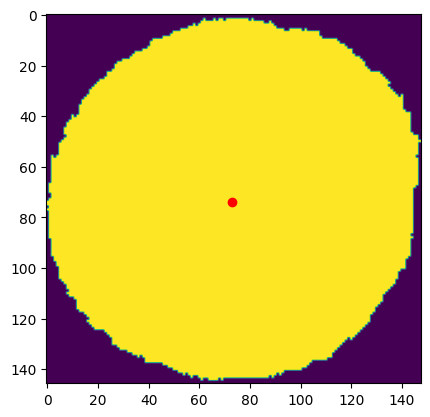

In [14]:
top = 8
bottom = 154
left = 44
right = 192
x = (bottom-top)/2
y = (right -left)/2
plt.scatter(x,y,color='r')
plt.imshow(markers[top:bottom,left:right])

In [15]:
from copy import deepcopy as dcpy 
contours, hier = cv2.findContours(dcpy(markers),cv2.RETR_FLOODFILL,cv2.CHAIN_APPROX_SIMPLE)
r = cv2.drawContours(markers, contours,-1,(255,0,0),1)
plt.imshow(r)
# plt.imshow(img_uint8,alpha=0.5)
plt.show()

error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/contours.cpp:195: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


In [ ]:
cropped = img_uint8[top:bottom,left:right]
ret,thresh = cv2.threshold(cropped,191,255,0)
print(thresh.shape,thresh)
M = cv2.moments(thresh)
plt.subplot(1,2,1)
plt.imshow(thresh)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
print(cX, cY)
t = cv2.circle(dcpy(cropped), (cX, cY), 5, (0, 0, 0), -1)
plt.subplot(1,2,2)
plt.imshow(t,alpha=1)

In [ ]:
print(thresh[100][185:250])
plt.imshow(thresh)

In [ ]:

retval = cv2.floodFill(markers, 
plt.imshow(retval)

In [ ]:
thresh.dtype, markers_uint.dtype

In [ ]:
print(np.unique(markers))
markers_uint = dcpy(markers)
markers_uint[markers_uint==-1] = 127
markers_uint = markers_uint.astype('uint8')
print(np.unique(markers_uint),markers_uint.dtype)
M = cv2.moments(markers_uint)
print(M)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
print(cX, cY)
t = cv2.circle(markers_uint, (cX, cY), 5, (0, 0, 0), -1)
plt.imshow(t,alpha=0.4)


In [ ]:
t = np.zeros((512,512),dtype=np.uint8)
# plt.imshow(t)
for c in contours:
   # calculate moments for each contour
    print(type(c),c.shape)
    M = cv2.moments(c)
    #print(M.keys())
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    print('centroid: X:{}, Y:{}'.format(cX, cY)) 
    t = cv2.circle(t, (cX, cY), 5, (255, 255, 255), -1)
plt.imshow(t)
    # break

In [ ]:
cv2.circle?

In [ ]:
cv2.findContours?

In [ ]:
cv2.moments?

In [ ]:
cv2.circle?
